# 2D MRF Subspace Reconstruction with Toeplitz Embedding (Simulated Data)

This demo will be based on Sigpy. We will start by loading the relvant libraries and simulating a time-series of images to reconstruct

In [2]:
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import matplotlib.pyplot as plt
from subspace_linops import A_subspace
from seq_utils import *

# GPU usage 
dev_idx = 0 # set to -1 if CPU
dev = sp.Device(dev_idx)
mvc = lambda x : sp.to_device(x, sp.cpu_device)
mvd = lambda x : sp.to_device(x, dev)
xp = dev.xp

# Parameters
img_size = (256, 256) # Image dimensions
N_T = 500             # Number of time points
N_alpha = 4           # Number of subspace coefficients (we precomputed this)
N_coil = 12           # Number of coils
sigma = 1e-8          # Noise standard deviation

# Random number gen
rng = np.random.default_rng(100)

# Sensitivity maps
mps = mr.birdcage_maps((N_coil, *img_size))

## Simulating Data

We now simulate a time-series of images and temporal subspace matrix. It is not important how we simulated the time-series images `x` and subspace matrix `phi`. Just know that `phi` is usually computed before the scan, and is a function of the sequence parameters. 

(-0.5, 255.5, 255.5, -0.5)

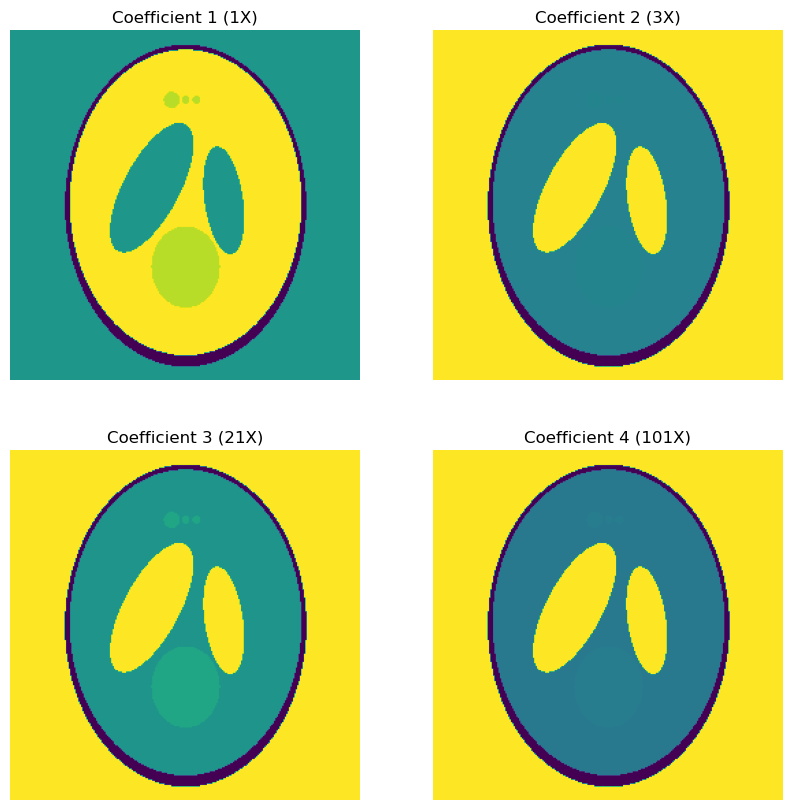

In [3]:
# Simuate time series of images as a time-evolving exponential with parameters dependent on value of base image
base = sp.shepp_logan(img_size)
base /= base.max()
vals = np.unique(base.flatten())
T1 = base.real * 0
T2 = base.real * 0
PD = np.abs(base)
for val in vals:
    inds = np.argwhere(np.abs(base - val) < 1e-3)
    t1 = rng.uniform(100e-3, 1000e-3)
    t2 = rng.uniform(40e-3, 1000e-3)
    t2 = min(t2, t1 - 10e-3)
    T1[inds[:, 0], inds[:, 1]] = t1
    T2[inds[:, 0], inds[:, 1]] = t2
TE = 3e-3
TR = 12e-3
trs = np.arange(N_T)
FA_train = gen_FA_train(N_T)
D_subspace = gen_dict(TE=TE,
                      TR=TR,
                      FA_train=FA_train,
                      t1_range=(100e-3, 1000e-3, 100),
                      t2_range=(40e-3, 1000e-3, 100),
                      pd_range=(PD.min(), PD.max(), 100))
params = (T1.flatten(), T2.flatten(), PD.flatten())
sigs = gen_dict(TE=TE,
                TR=TR,
                FA_train=FA_train,
                params=params)
x_GT = sigs.T.reshape((N_T, *img_size))

# Find temporal subspace
U, s, Vt = np.linalg.svd(D_subspace, full_matrices=False)
phi = Vt[:N_alpha, :]

# Ground truth coefficients
alpha_GT = np.sum(phi[..., None, None].conj() * x_GT[None, :, ...], axis=1)

# Show ground truth coefficients
plt.figure(figsize=(10, 10))
alpha_max = np.abs(alpha_GT).max()
for i in range(N_alpha):
    plt.subplot(2, 2, i+1)
    img = np.abs(alpha_GT[i])
    vmax = img.max()
    plt.title(f'Coefficient {i+1} ({int(alpha_max/vmax)}X)')
    plt.imshow(img, vmin=0, vmax=vmax)
    plt.axis('off')
plt.subplot(2, 2, 4)
plt.axis('off')

We will use 32 interleaves to cover the entired kx-ky space, and will choose an interleave for each time point

In [4]:
# Design a spiral trajectory to cover all of k-space in 32 interleaves
n_interleaves = 32
trj = mr.spiral(
        fov=1,
        N=img_size[0],
        f_sampling=0.5,
        R=1,
        ninterleaves=n_interleaves,
        alpha=1.5,
        gm=40e-3, # Tesla / m 
        sm=100, # Tesla / m / s
    )
trj = trj.reshape((trj.shape[0] // n_interleaves, n_interleaves, 2), order='F')

# For time series acquisiton, just repeat 32 interleaves. 
# Example: t = 1 -> interleave 1, t = 2 -> interleave 2 
# ... t = 32 -> interleave 32, t = 33 -> interleave 1
trj = np.tile(trj, reps=(1, int(np.ceil(N_T / n_interleaves)), 1))[:, None, :N_T, :]

# And get DCF
dcf = mvc(mr.pipe_menon_dcf(trj, img_size, device=dev))

PipeMenonDCF: 100%|██████████| 30/30 [00:01<00:00, 18.71it/s, resid=3.15E-02]


The subspace forward operator will apply NUUFTs, sensitivity maps, and the temporal subspace matrix to simulate acquired data from the scanner. There are two non-intuitive points to cover here:
1. We are moving the subspace images from each coil on and off GPU to help with memory constraints.
2. The subspace matrix `phi` is a temporal operator, and hence can commute with spatial operators like the NUFFT and sensitivity map operations.

In [5]:
# Create forward model
with dev:
    sqrt_dcf_gpu = xp.sqrt(mvd(dcf))
    phi_gpu = mvd(phi)
    mps_gpu = mvd(mps)
    trj_gpu = mvd(trj)
As = A_subspace(trj_gpu, phi_gpu, mps_gpu, sqrt_dcf_gpu, fast_AHA=False)
As_toeplitz = A_subspace(trj_gpu, phi_gpu, mps_gpu, sqrt_dcf_gpu, fast_AHA=True)

# Simulate data
ksp = As * alpha_GT
ksp += np.random.normal(0, sigma, ksp.shape) + 1j * np.random.normal(0, sigma, ksp.shape)


Calculating Toeplitz Embeddings
Time = 0.758s


## Subspace Toeplitz Reconstruction

Finally we will perform a CG-SENSE reconstruction with and without the toeplitz graham operator

In [6]:
alpha_regular = sp.app.LinearLeastSquares(
    A=As,
    y=ksp,
    x=As.H * ksp,
    max_iter=10,
    solver='ConjugateGradient',
    show_pbar=True
).run()
alpha_toeplitz = sp.app.LinearLeastSquares(
    A=As_toeplitz,
    y=ksp,
    x=As_toeplitz.H * ksp,
    max_iter=10,
    solver='ConjugateGradient',
    show_pbar=True
).run()

LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, resid=2.20E-13]


And here are the final reconstructions

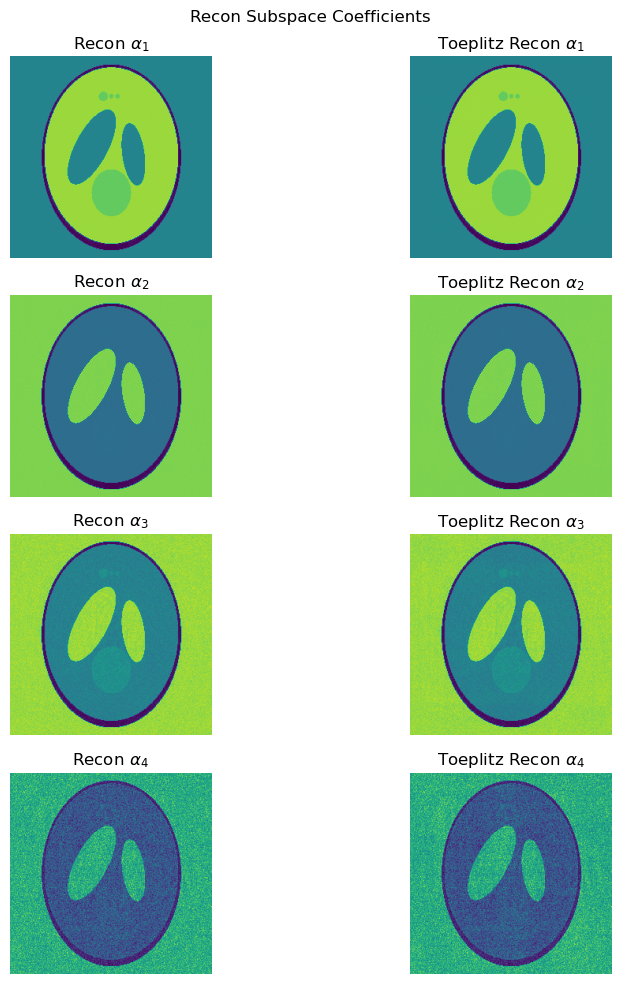

In [7]:
plt.figure(figsize=(10, 10))
plt.suptitle('Recon Subspace Coefficients')
for k in range(N_alpha):
    plt.subplot(N_alpha, 2, 2 * k + 1)
    plt.title('Recon ' + r'$\alpha_{{{}}}$'.format(k+1))
    plt.imshow(np.abs(alpha_regular[k]))
    plt.axis('off')
    plt.subplot(N_alpha, 2, 2 * k + 2)
    plt.title('Toeplitz Recon ' + r'$\alpha_{{{}}}$'.format(k+1))
    plt.imshow(np.abs(alpha_toeplitz[k]))
    plt.axis('off')
plt.tight_layout()